Main idea: Fetch multiple datasets of indexes and stocks correlated news to that index. (News only go back one year)
Then we train the model on the multiple datasets and test it on the last dataset.

1. Fetch the stock data from Yahoo Finance
2. Fetch the news data from NewsAPI
3. Preprocess stock data. We will give the model open, close, high, low
4. Preprocess news data to sentiment labels. then backfill the sentiment labels so that there are no missing values
5. Merge the stock data and news data
6. Train the model on the multiple datasets
7. Test the model on the last dataset
8. Evaluate the model
9. Save the model
10. Make predictions

In [72]:
#Data fetching 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from pygooglenews import GoogleNews

In [73]:
#List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX']
#List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX', 'XLE', 'AAPL','MSFT','GOOGL','BRK-A','JPM','JNJ','V','WMT','PG','UNH','MA','INTC','VZ','HD','DIS','MRK','KO','PFE','BAC','PEP','CSCO','CMCSA','NFLX','T','ADBE','ABT','XOM','CRM','TMO','ACN','CVX','NKE']

List_of_indexes = ['ABB.ST', 'ALFA.ST', 'ASSA-B.ST', 'AZN.ST', 'ATCO-A.ST', 'ATCO-B.ST','BOL.ST', 'ELUX-B.ST', 'ERIC-B.ST', 'ESSITY-B.ST', 'EVO.ST', 'GETI-B.ST', 'HM-B.ST', 'HEXA-B.ST', 'INVE-B.ST', 'KINV-B.ST', 'NDA-SE.ST', 'SAND.ST', 'SINCH.ST', 'SEB-A.ST', 'SKA-B.ST', 'SKF-B.ST', 'SCA-B.ST', 'SHB-A.ST', 'SWED-A.ST', 'TEL2-B.ST', 'TELIA.ST', 'VOLV-B.ST']

#List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX', 'XLE', 'AAPL','MSFT','AMZN','GOOGL','TSLA','BRK-A','JPM','JNJ','V','WMT','PG','UNH','MA','INTC','VZ','HD','DIS','MRK','KO','PFE','BAC','PEP','CSCO','CMCSA','NFLX','T','NVDA','ADBE','ABT','XOM','CRM','TMO','ACN','CVX','NKE','LLY','COST','ABBV','DHR','NEE','AVGO','MDT','QCOM','TXN','UNP','LIN','UPS','HON','SBUX','AMT','ORCL','LOW','IBM','MO','AMD','AMGN','C','CAT','BA','MMM','GE','GS','MS','FDX','PYPL','CHTR','AMAT','LMT']

#List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX', 'XLE', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'BRK-A', 'JPM', 'JNJ', 'V', 'WMT', 'PG', 'UNH', 'MA', 'INTC', 'VZ', 'HD', 'DIS', 'MRK', 'KO', 'PFE', 'BAC', 'PEP', 'CSCO', 'CMCSA', 'NFLX', 'T', 'NVDA', 'ADBE', 'ABT', 'XOM', 'CRM', 'TMO', 'ACN', 'CVX', 'NKE', 'LLY', 'COST', 'ABBV', 'DHR', 'NEE', 'AVGO', 'MDT', 'QCOM', 'TXN', 'UNP', 'LIN', 'UPS', 'HON', 'SBUX', 'AMT', 'ORCL', 'LOW', 'IBM', 'MO', 'AMD', 'AMGN', 'C', 'CAT', 'BA', 'MMM', 'GE', 'GS', 'MS', 'FDX', 'PYPL', 'CHTR', 'AMAT', 'LMT', 'META', 'SNOW', 'PANW', 'SHOP', 'UBER', 'BP', 'CVX', 'SLB', 'COP', 'ISRG', 'GILD', 'BIIB', 'REGN', 'MCD', 'TGT', 'ROST', 'SCHW', 'BLK', 'AXP', 'BK', 'TSM', 'BABA', 'NTES', 'JD', 'TCEHY', 'NESN.SW', 'RACE', 'ASML', 'SAP.DE', 'PBR', 'VALE', 'ITUB', 'NIO', 'LI', 'RIVN', 'LCID', 'MU', 'ENPH', 'SEDG', 'FSLR', '^VIX', '^RUA', '^AEX', '^STOXX50E', '^BSESN', '^KS11', 'XLV','XLF', 'XLK', 'XLY', 'XLP', 'XLU', 'XLB', 'XLI']

In [74]:
#Fetch stock data
stock_data = {}
for index in List_of_indexes:
    #Manually create the dataframe
    collected_data = yf.download(index, period ="1y")
    df = pd.DataFrame()
    df['Open'] = collected_data['Open']
    df['Close'] = collected_data['Close']
    df['High'] = collected_data['High']
    df['Low'] = collected_data['Low']
    df['Volume'] = collected_data['Volume']
    stock_data[index] = df
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [75]:
#Fetch news data
news_data = {}
gn = GoogleNews()
for index in List_of_indexes:
    news_data[index] = gn.search(index, when='1y')
    print("Fetched news data for: ", index)
    print("Number of articles: ", len(news_data[index]['entries']))
    #Convert to dataframe
    news_data[index] = pd.DataFrame(news_data[index]['entries'])




Fetched news data for:  ABB.ST
Number of articles:  58
Fetched news data for:  ALFA.ST
Number of articles:  52
Fetched news data for:  ASSA-B.ST
Number of articles:  18
Fetched news data for:  AZN.ST
Number of articles:  31
Fetched news data for:  ATCO-A.ST
Number of articles:  9
Fetched news data for:  ATCO-B.ST
Number of articles:  7
Fetched news data for:  BOL.ST
Number of articles:  51
Fetched news data for:  ELUX-B.ST
Number of articles:  17
Fetched news data for:  ERIC-B.ST
Number of articles:  65
Fetched news data for:  ESSITY-B.ST
Number of articles:  5
Fetched news data for:  EVO.ST
Number of articles:  74
Fetched news data for:  GETI-B.ST
Number of articles:  8
Fetched news data for:  HM-B.ST
Number of articles:  20
Fetched news data for:  HEXA-B.ST
Number of articles:  7
Fetched news data for:  INVE-B.ST
Number of articles:  45
Fetched news data for:  KINV-B.ST
Number of articles:  30
Fetched news data for:  NDA-SE.ST
Number of articles:  5
Fetched news data for:  SAND.ST
Nu

In [76]:
#Print the news data for OMX index
news_data['VOLV-B.ST'].head(50)

,title,title_detail,links,link,id,guidislink,published,published_parsed,summary,summary_detail,source,sub_articles
0,We Think AB Volvo's (STO:VOLV B) Solid Earning...,"{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMi0wFBV...,CBMi0wFBVV95cUxPZEdMZEdfUEdmWG9pYVE0bXFUUkQxeU...,False,"Sat, 26 Oct 2024 07:00:00 GMT","(2024, 10, 26, 7, 0, 0, 5, 300, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'https://simplywall.st', 'title': 'Si...",[]
1,AB Volvo (OM:VOLV B) Reports Q3 Earnings Decli...,"{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMickFVX...,CBMickFVX3lxTE1IaklyOWlFZzRqWXdfWXpCWlE1eG5lRE...,False,"Sat, 09 Nov 2024 08:00:00 GMT","(2024, 11, 9, 8, 0, 0, 5, 314, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'https://finance.yahoo.com', 'title':...",[]
2,Truckmaker Volvo beats profit expectations but...,"{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMi1wFBV...,CBMi1wFBVV95cUxNdndQQ2VBMkhVTEZHQ3J1QU5sYWw4ZW...,False,"Thu, 18 Jul 2024 07:00:00 GMT","(2024, 7, 18, 7, 0, 0, 3, 200, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'https://www.reuters.com', 'title': '...",[]
3,"Director of AB Volvo Picks Up 18,750% More Sto...","{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMiwgFBV...,CBMiwgFBVV95cUxOa0VuMU1KRDcxYndub0pMdFFCVlR3Yz...,False,"Sun, 24 Nov 2024 08:00:00 GMT","(2024, 11, 24, 8, 0, 0, 6, 329, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'https://simplywall.st', 'title': 'Si...",[]
4,Sweden stocks lower at close of trade; OMX Sto...,"{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMivAFBV...,CBMivAFBVV95cUxNTDUzTFdodXZacktyQ280THNKYVRmVX...,False,"Tue, 19 Nov 2024 08:00:00 GMT","(2024, 11, 19, 8, 0, 0, 1, 324, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'https://www.investing.com', 'title':...",[]
5,Volvo (VOLVB) Earnings Decline on Waning Freig...,"{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMisAFBV...,CBMisAFBVV95cUxOZUpzT2NodDBqSmNMb21RcHhxbzJ1UE...,False,"Fri, 18 Oct 2024 07:00:00 GMT","(2024, 10, 18, 7, 0, 0, 4, 292, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'https://www.bloomberg.com', 'title':...",[]
6,Sweden stocks lower at close of trade; OMX Sto...,"{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMivAFBV...,CBMivAFBVV95cUxQVjJrWndNSUtwdW44dkg4OHVjVjBIdj...,False,"Mon, 16 Dec 2024 08:00:00 GMT","(2024, 12, 16, 8, 0, 0, 0, 351, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'https://www.investing.com', 'title':...",[]
7,Should You Investigate AB Volvo (publ) (STO:VO...,"{'type': 'text/plain', 'language': None, 'base...","[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://news.google.com/rss/articles/CBMizgFBV...,CBMizgFBVV95cUxQVElnbkhNME9ETWFMdzhqb0xwZGVmNk...,False,"Wed, 20 Nov 2024 08:00:00 GMT","(2024, 11, 20, 8, 0, 0, 2, 325, 0)","<a href=""https://news.google.com/rss/articles/...","{'type': 'text/html', 'language': None, 'base'...","{'href': 'h

In [77]:
#Clean up the news data wich contains: title,title_detail,links,link,id,guidislink,published,published_parsed,summary,summary_detail,source,sub_articles
#We will put the title through a sentiment analysis model and then put all none existing values as 0
#Finbert model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

#Test the model
from transformers import pipeline

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


news_sentiments = {}

#Add date and sentiment to the dataframe
for index in List_of_indexes:
    news_sentiments[index] = []
    print("Processing news data for: ", index)
    for i in range(len(news_data[index])):
        #print(news_data[index].iloc[i]['title'])
        sentiment = classifier(news_data[index].iloc[i]['title'], top_k=None)
        postive_score = sentiment[0]['score']
        negative_score = sentiment[1]['score']
        neutral_score = sentiment[2]['score']
        #Convert date to dtype='datetime64[ns] so that we can later can merge the dataframes
        reformmated_time_stamp = pd.to_datetime(news_data[index].iloc[i]['published']).date()
        news_sentiments[index] = news_sentiments[index] + [{'Date': reformmated_time_stamp, 'positive_score': postive_score, 'negative_score': negative_score, 'neutral_score': neutral_score}]
    news_sentiments[index] = pd.DataFrame(news_sentiments[index])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0


Processing news data for:  ABB.ST
Processing news data for:  ALFA.ST
Processing news data for:  ASSA-B.ST
Processing news data for:  AZN.ST
Processing news data for:  ATCO-A.ST
Processing news data for:  ATCO-B.ST
Processing news data for:  BOL.ST
Processing news data for:  ELUX-B.ST
Processing news data for:  ERIC-B.ST
Processing news data for:  ESSITY-B.ST
Processing news data for:  EVO.ST
Processing news data for:  GETI-B.ST
Processing news data for:  HM-B.ST
Processing news data for:  HEXA-B.ST
Processing news data for:  INVE-B.ST
Processing news data for:  KINV-B.ST
Processing news data for:  NDA-SE.ST
Processing news data for:  SAND.ST
Processing news data for:  SINCH.ST
Processing news data for:  SEB-A.ST
Processing news data for:  SKA-B.ST
Processing news data for:  SKF-B.ST
Processing news data for:  SCA-B.ST
Processing news data for:  SHB-A.ST
Processing news data for:  SWED-A.ST
Processing news data for:  TEL2-B.ST
Processing news data for:  TELIA.ST
Processing news data for

In [78]:
#Check news sentiment for VOLV-B.ST
news_sentiments['VOLV-B.ST'].head(50)

,Date,positive_score,negative_score,neutral_score
0,2024-10-26,0.924490,0.043542,0.031968
1,2024-11-09,0.969373,0.022799,0.007828
2,2024-07-18,0.868048,0.093548,0.038404
3,2024-11-24,0.558590,0.428496,0.012914
4,2024-11-19,0.957204,0.034345,0.008452
5,2024-10-18,0.973729,0.017117,0.009154
6,2024-12-16,0.956815,0.034655,0.008530
7,2024-11-20,0.939420,0.041585,0.018995
8,2024-04-11,0.899699,0.083163,0.017138
9,2024-12-27,0.628737,0.275446,0.095817


In [79]:
# Average sentiment for days with multiple articles

for index in List_of_indexes:
    # Group by date and calculate mean sentiment scores
    news_sentiments[index] = (
        news_sentiments[index]
        .groupby('Date')
        .mean()
        .fillna(0)  # Handle NaN values
        .reset_index()  # Ensure 'date' becomes a column
        .set_index('Date')  # Set 'date' as the index
        .sort_index()  # Ensure the index is sorted
    )
    
    
# Define a common date range
common_index = pd.date_range(
    start=pd.Timestamp(min(pd.Timestamp(stock_data[index].index.min()), pd.Timestamp(news_sentiments[index].index.min()))),
    end=pd.Timestamp(max(pd.Timestamp(stock_data[index].index.max()), pd.Timestamp(news_sentiments[index].index.max()))),
    freq='D'  # Daily frequency
)

# Reindex both dataframes so they have the same index
stock_data[index] = stock_data[index].reindex(common_index).fillna(-1)  # Fill missing stock data with 0
news_sentiments[index] = news_sentiments[index].reindex(common_index).fillna(0)  # Fill missing sentiment data with 0

# Combine stock data and news sentiment into one DataFrame
combined_data = {}


# Reindex both dataframes

for index in List_of_indexes:
    # Ensure stock_data and news_sentiments have compatible indices
    stock_data[index].index = pd.to_datetime(stock_data[index].index).normalize()  # Normalize index to date only
    news_sentiments[index].index = pd.to_datetime(news_sentiments[index].index).normalize()  # Normalize index to date only
    
    # Merge stock data and news data
    combined_data[index] = pd.merge(
        stock_data[index], 
        news_sentiments[index], 
        how='left', 
        left_index=True, 
        right_index=True
    )
    
    #Drop all close values that are -1
    combined_data[index] = combined_data[index][combined_data[index].Close != -1]
    
    #Fill all missing values with 0
    combined_data[index] = combined_data[index].fillna(0)
    


In [80]:
#Check size of the dataframes
for index in List_of_indexes:
    print("Size of dataframe for ", index, " is: ", combined_data[index].shape)

Size of dataframe for  ABB.ST  is:  (250, 8)
Size of dataframe for  ALFA.ST  is:  (250, 8)
Size of dataframe for  ASSA-B.ST  is:  (250, 8)
Size of dataframe for  AZN.ST  is:  (250, 8)
Size of dataframe for  ATCO-A.ST  is:  (250, 8)
Size of dataframe for  ATCO-B.ST  is:  (250, 8)
Size of dataframe for  BOL.ST  is:  (250, 8)
Size of dataframe for  ELUX-B.ST  is:  (250, 8)
Size of dataframe for  ERIC-B.ST  is:  (250, 8)
Size of dataframe for  ESSITY-B.ST  is:  (250, 8)
Size of dataframe for  EVO.ST  is:  (250, 8)
Size of dataframe for  GETI-B.ST  is:  (250, 8)
Size of dataframe for  HM-B.ST  is:  (250, 8)
Size of dataframe for  HEXA-B.ST  is:  (250, 8)
Size of dataframe for  INVE-B.ST  is:  (250, 8)
Size of dataframe for  KINV-B.ST  is:  (250, 8)
Size of dataframe for  NDA-SE.ST  is:  (250, 8)
Size of dataframe for  SAND.ST  is:  (250, 8)
Size of dataframe for  SINCH.ST  is:  (250, 8)
Size of dataframe for  SEB-A.ST  is:  (250, 8)
Size of dataframe for  SKA-B.ST  is:  (250, 8)
Size of dat

In [81]:
#Test of news decay 
#We will backfill the news data so that a news article will have an time decay

decay_factor = 0.7

for index in List_of_indexes:
    df = combined_data[index]

    for i in range(1, len(df)):
        # Use iloc for position-based access to rows
        if df.iloc[i]['positive_score'] == 0 and df.iloc[i-1]['positive_score'] != 0:
            df.iloc[i, df.columns.get_loc('positive_score')] = df.iloc[i-1, df.columns.get_loc('positive_score')] * decay_factor
        if df.iloc[i]['negative_score'] == 0 and df.iloc[i-1]['negative_score'] != 0:
            df.iloc[i, df.columns.get_loc('negative_score')] = df.iloc[i-1, df.columns.get_loc('negative_score')] * decay_factor
        if df.iloc[i]['neutral_score'] == 0 and df.iloc[i-1]['neutral_score'] != 0:
            df.iloc[i, df.columns.get_loc('neutral_score')] = df.iloc[i-1, df.columns.get_loc('neutral_score')] * decay_factor

    combined_data[index] = df



    


In [84]:
#Reformat the dataframes to be able to train the model
#We will use the last 30 days as testa data and the rest as training data as the data comes from diffrent indexes
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


def create_sequences(input_data, output_data, timesteps, output_dim):
    xs, ys = [], []
    for i in range(len(input_data) - output_dim - timesteps):
        x = input_data[i:(i + timesteps)]
        y = output_data[i + timesteps:i + output_dim + timesteps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

timesteps = 30
input_dim = 8
output_dim = 5 #Predict 5 days ahead


# Initialize global scalers
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# Gather all data for global scaling
xs = []
ys = []
for index in List_of_indexes: 
    data = combined_data[index]
    # Normalize data
    input_features = data[['Open', 'Close', 'High', 'Low','Volume', 'positive_score', 'negative_score', 'neutral_score']].values
    output_feature = data[['Close']].values
    scaler = MinMaxScaler()
    input_features_scaled = scaler.fit_transform(input_features)
    output_feature_scaled = scaler.fit_transform(output_feature)
    
    # Create sequences
    x, y = create_sequences(input_features_scaled, output_feature_scaled, timesteps, output_dim)
    xs.append(x)
    ys.append(y)
    
# Concatenate all sequences
xs = np.concatenate(xs)
ys = np.concatenate(ys)

print(xs.shape, ys.shape)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, shuffle=False)

print(xs.shape, ys.shape)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)


(6020, 30, 8) (6020, 5, 1)
(6020, 30, 8) (6020, 5, 1)


In [85]:
model = Sequential() 
model.add(LSTM(128, input_shape=(timesteps, input_dim)))
model.add(Dense(64, activation='relu'))


model.add(Dense(output_dim))


model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])


Epoch 1/100


/Users/palhagen/.virtualenvs/Scalable_Machine_learning_Project/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0644 - val_loss: 0.0146
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0099 - val_loss: 0.0110
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0094 - val_loss: 0.0104
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch 10/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 11/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 12/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 

In [86]:
#Evaluate the model
test_results = model.evaluate(x_test, y_test)
test_loss = test_results
print(f'Test Loss: {test_loss}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Test Loss: 0.006012920755892992


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


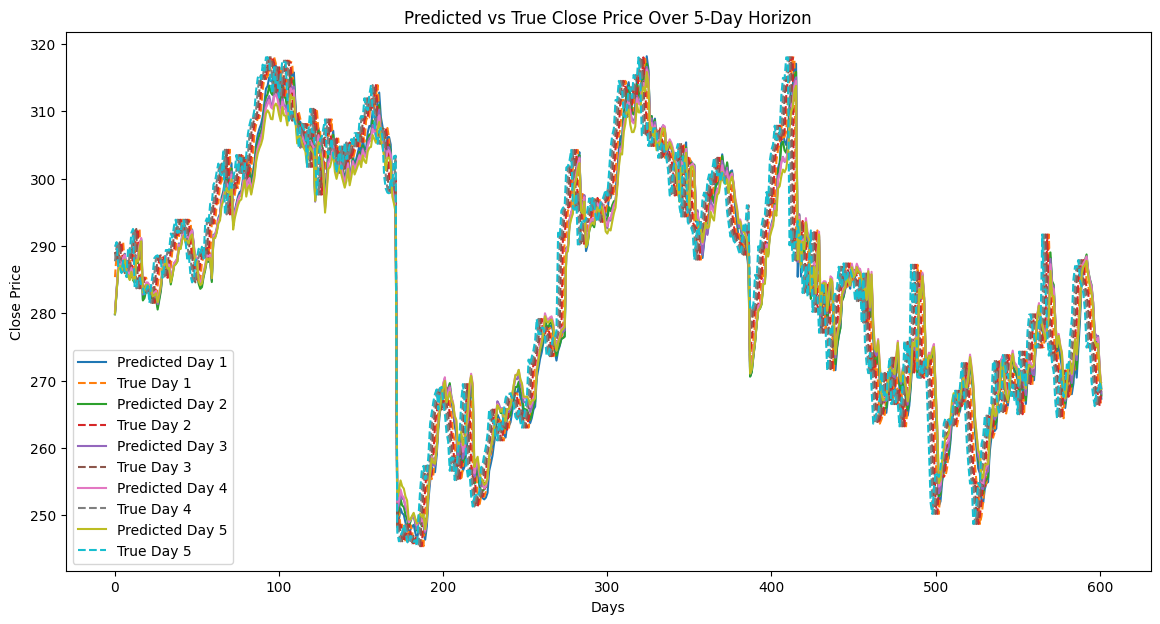

In [87]:
# Make predictions
predictions = model.predict(x_test)

# Reshape y_test from (390, 5, 1) to (390, 5)
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])

# Inverse transform predictions and y_test
predictions_unscaled = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test_reshaped)

# Plot predictions vs. true values
plt.figure(figsize=(14, 7))

# Plot for each of the 5 prediction days
for i in range(5):  # 5 prediction steps
    plt.plot(
        range(len(predictions_unscaled[:, i])),
        predictions_unscaled[:, i],
        label=f'Predicted Day {i + 1}',
    )
    plt.plot(
        range(len(y_test_unscaled[:, i])),
        y_test_unscaled[:, i],
        linestyle='--',
        label=f'True Day {i + 1}',
    )

plt.ylabel('Close Price')
plt.xlabel('Days')
plt.title('Predicted vs True Close Price Over 5-Day Horizon')
plt.legend()
plt.show()


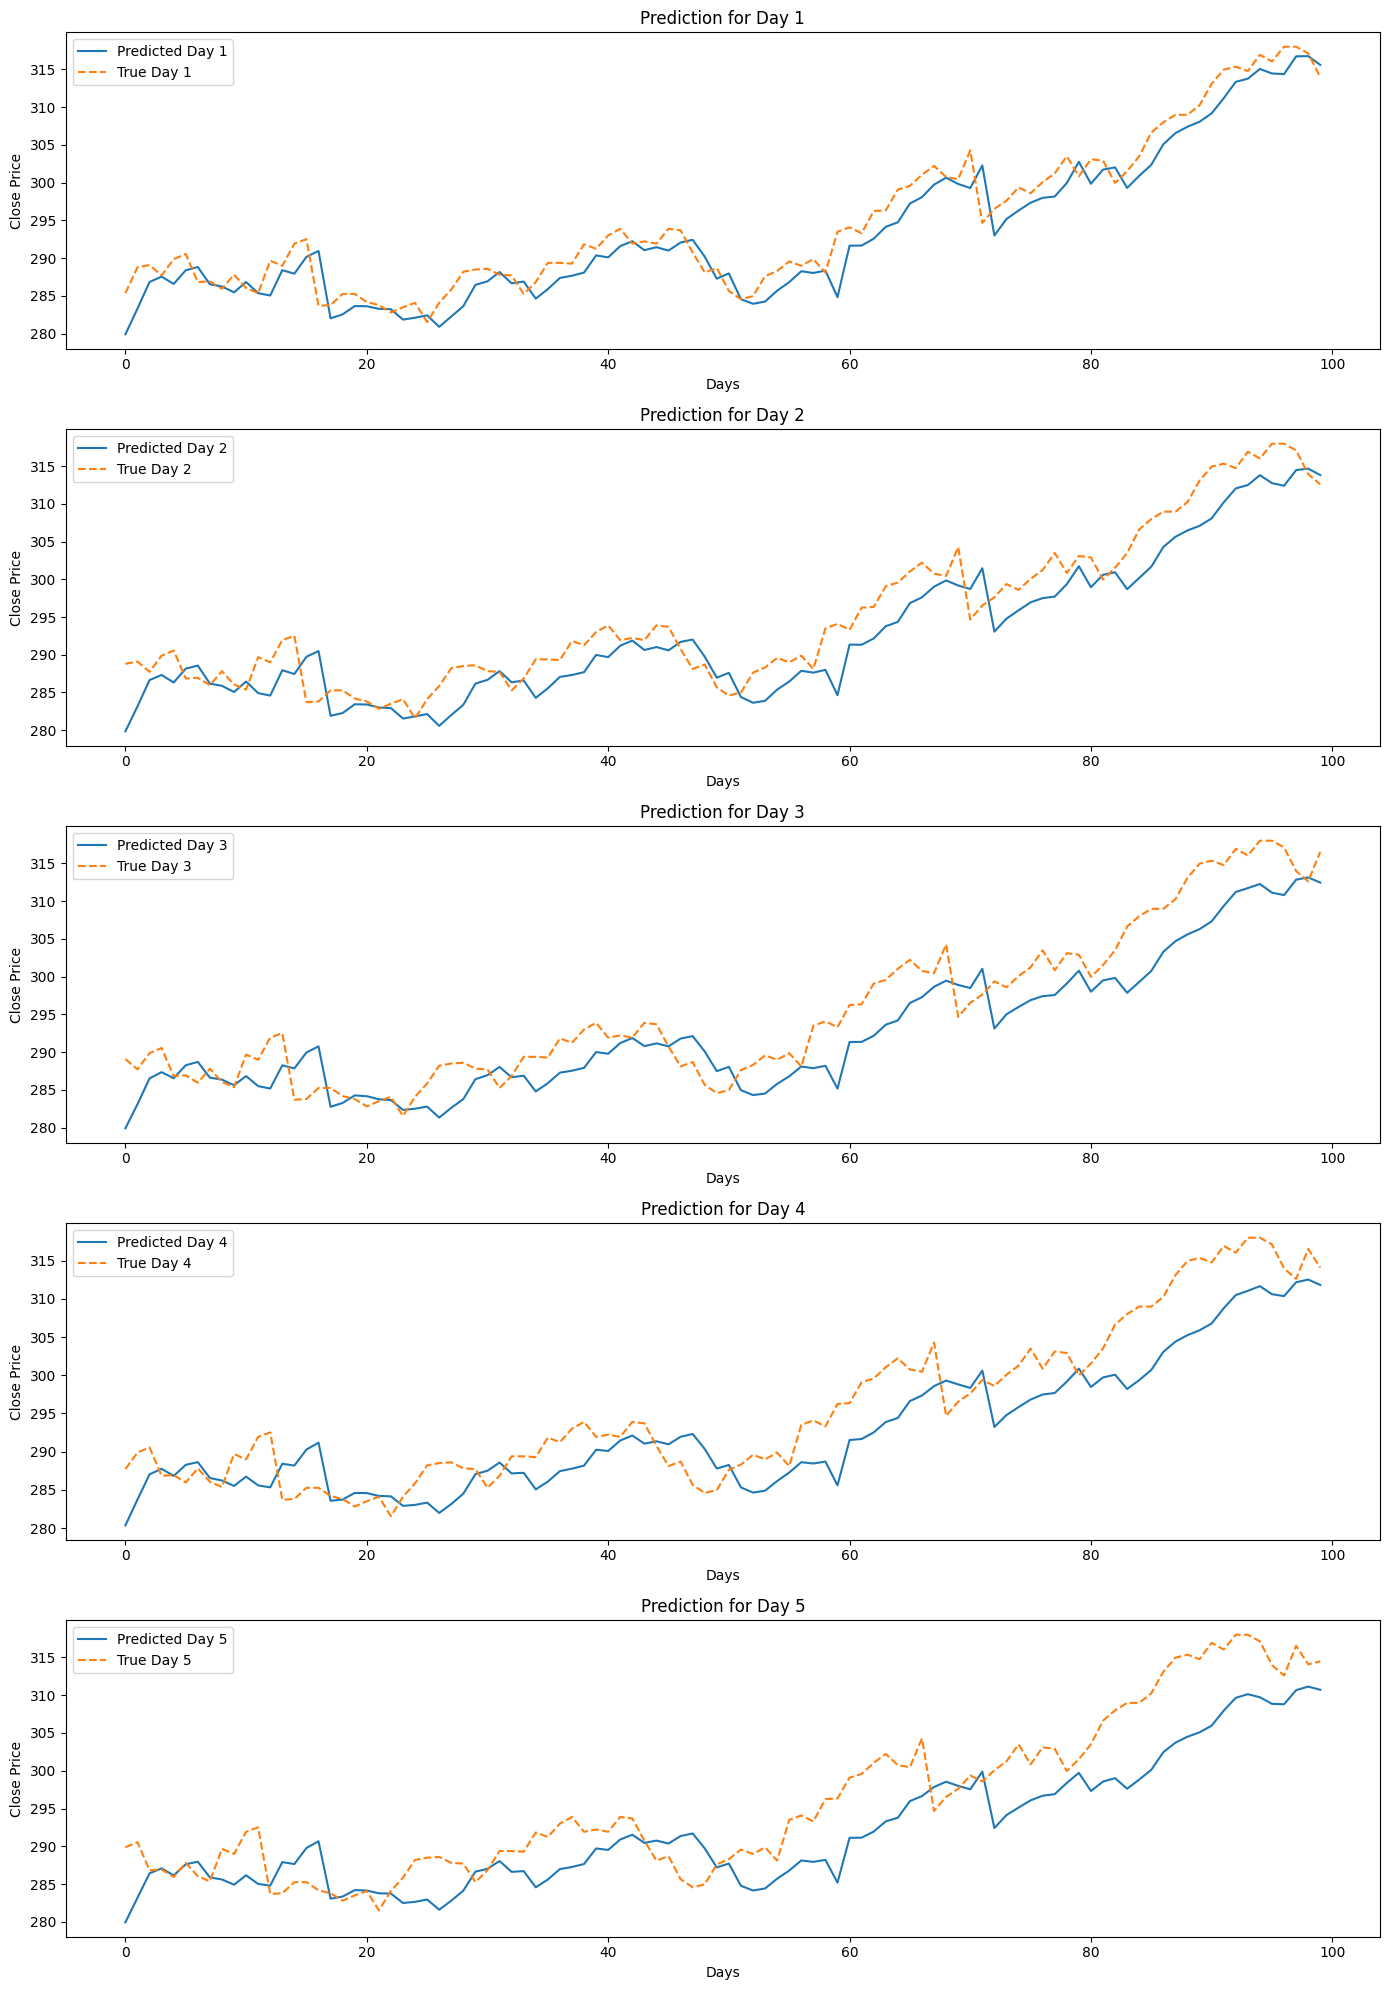

In [91]:
# Plot predictions and true values in separate subplots
plt.figure(figsize=(14, 20))

start = 0
end = 100



for i in range(5):  # 5 prediction steps
    plt.subplot(5, 1, i + 1)  # Create 5 subplots, one for each prediction day
    plt.plot(
        range(start, end),
        predictions_unscaled[start:end, i],
        label=f'Predicted Day {i + 1}',
    )
    plt.plot(
        range(start, end),
        y_test_unscaled[start:end, i],
        linestyle='--',
        label=f'True Day {i + 1}',
    )
    plt.ylabel('Close Price')
    plt.xlabel('Days')
    plt.title(f'Prediction for Day {i + 1}')
    plt.legend()

plt.tight_layout()
plt.show()


In [92]:
#Save the model to hopsworks
import hopsworks
import os
import warnings
from hsml.schema import Schema
from hsml.model_schema import ModelSchema


In [93]:
with open('./project_api_key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
    print("API Key is set")
    print("First 5 characters of API Key: ", os.environ["HOPSWORKS_API_KEY"][:5])

API Key is set
First 5 characters of API Key:  pwWjy


In [94]:
model_dir = "FinanceModel"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [ ]:
#Get loss of model 


In [95]:
project = hopsworks.login() 

model_dir = "Resources/Models"

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(x_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()
model.save(model_dir + "/model.keras") 

#Save the scalers as well
import joblib

joblib.dump(scaler, model_dir + "/scaler.pkl") 


mr = project.get_model_registry()

#Get model metrics

res_dict = {
    "MSE" : test_loss
}

aq_model = mr.python.create_model(
    name="FinanceModel", 
    metrics= res_dict,
    model_schema=model_schema,
    description="Predicting stock prices using LSTM model trained on multiple indexes.",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)


2025-01-07 14:04:33,924 INFO: Initializing external client
2025-01-07 14:04:33,924 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 14:04:35,314 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1168540


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/725 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/973703 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/725 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/863608 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/965 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/222 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1168540/models/FinanceModel/11


Model(name: 'FinanceModel', version: 11)